In [1]:
import sys

In [2]:
sys.path.append("C:\\Users\\mohan\\Documents\\GitHub\\Reinforcement-Learning\\rl\\DynamicProgramming")

In [3]:
sys.path.append("C:\\Users\\mohan\\Documents\\GitHub\\Reinforcement-Learning\\rl\\MonteCarlo")

In [4]:
sys.path.append("C:\\Users\\mohan\\Documents\\GitHub\\Reinforcement-Learning\\rl\\TemporalDifferenceLearning")

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy
from monte_carlo_exploring_starts import max_dict
from sarsa import random_action, ALPHA, GAMMA, ALL_POSSIBLE_ACTION

In [16]:
SA2IDX = {}
IDX = 0

In [17]:
def random_action_q_learing():
    '''We will use epsilon soft to ensure that all the states are visited. If set eps=0 some states may never be visited. '''
    return np.random.choice(list(ALL_POSSIBLE_ACTION))

In [18]:
class Model:
    def __init__(self):
        #initializing theta vector randomly.
        self.theta = np.random.randn(25)/np.sqrt(25)
    
    def state_action_sa_to_feature_x(self, s, a):
        #using (r, c, r*c, u, d, l, r, 1) is not expressive enough
        return np.array([
                    s[0] - 1                    if a == 'U' else 0,
                    s[1] - 1.5                  if a == 'U' else 0,
                    (s[0]*s[1]-3)/3             if a == 'U' else 0,
                    (s[0]*s[0]-2)/2             if a == 'U' else 0,
                    (s[1]*s[1]-4.5)/4.5         if a == 'U' else 0,
                    1                           if a == 'U' else 0,
                    s[0] - 1                    if a == 'D' else 0,
                    s[1] - 1.5                  if a == 'D' else 0,
                    (s[0]*s[1]-3)/3             if a == 'D' else 0,
                    (s[0]*s[0]-2)/2             if a == 'D' else 0,
                    (s[1]*s[1]-4.5)/4.5         if a == 'D' else 0,
                    1                           if a == 'D' else 0,
                    s[0] - 1                    if a == 'L' else 0,
                    s[1] - 1.5                  if a == 'L' else 0,
                    (s[0]*s[1]-3)/3             if a == 'L' else 0,
                    (s[0]*s[0]-2)/2             if a == 'L' else 0,
                    (s[1]*s[1]-4.5)/4.5         if a == 'L' else 0,
                    1                           if a == 'L' else 0,
                    s[0] - 1                    if a == 'R' else 0,
                    s[1] - 1.5                  if a == 'R' else 0,
                    (s[0]*s[1]-3)/3             if a == 'R' else 0,
                    (s[0]*s[0]-2)/2             if a == 'R' else 0,
                    (s[1]*s[1]-4.5)/4.5         if a == 'R' else 0,
                    1                           if a == 'R' else 0,
                    1])
    
        #if we use one hot encoding for every state and action (s, a) pair.
        #In reality we don't want to do this becuase we have just any parameter as before.
        #x = np.zeros(len(self.theta))
        #idx = SA2IDX[s][a]
        #x[idx] = 1
        #return x
    
    def predict(self, s, a):
        #Returns the predicted value of state given a state
        x = self.state_action_sa_to_feature_x(s, a)
        return self.theta.dot(x)
    
    def grad(self, s, a):
        #This function is not needed
        return self.state_action_sa_to_feature_x(s, a)
    
def getQs(model, s):
    #We need Q(s, a) to choose an action
    #i.e a = argmax[a]{Q(s, a)}
    Qs = {}
    for a in ALL_POSSIBLE_ACTION:
        q_sa = model.predict(s, a)
        Qs[a] = q_sa
    return Qs

In [19]:
def main():
    #using the standard grid will result in suboptimal policies
    grid = negative_grid(step_cost=-0.1)
    
    #print rewards
    print ("rewards")
    print_values(grid.rewards, grid)
    
    global IDX
    #No policy initialization, we will derive our policy from the most recent Q.
    states = grid.all_states()
    for s in states:
        SA2IDX[s] = {}
        for a in ALL_POSSIBLE_ACTION:
            SA2IDX[s][a] = IDX
            IDX += 1 
            
    #Initialize model.
    model = Model()
    
    #Repeat untill convergence
    deltas = []
    t1 = 1.0
    t2 = 1.0
    for it in range(20000):
        if it % 100 == 0:
            t1 += 0.001
            t2 += 0.01
        if it % 1000 == 0:
            print("it: ", it)
        alpha = ALPHA/t2
        
        #instead of genearating an episode, we will play an episode within this loop.
        s = (2, 0) #start_state
        grid.set_state(s)
        
        #get Q(s) so we can choose the first action.
        Qs = getQs(model, s)
        
        #the first(s, r) tuple is state we start in and 0(reward), since we get a reward simply starting the game.
        #the last(s, r) tuple is terminal state, so the value function is zero, so no need to update.
        
        a = max_dict(Qs)[0]
        a = random_action(a, eps=0.5/t1)
        biggest_change = 0
        while not grid.game_over():
            r = grid.move(a)
            s2 = grid.current_state()
            
            #we need next action also because Q(s, a) depends on Q(s', a')
            #if s2 is terminal we won't be able to take any action so we count only reward.
            
            old_theta = model.theta.copy()
            if grid.is_terminal(s2):
                model.theta += alpha*(r - model.predict(s, a))*model.grad(s, a)
            else:
                Qs2 = getQs(model, s2)
                a2 = max_dict(Qs2)[0]
                a2 = random_action(a2, eps=0.5/t1)
                
                model.theta += alpha * (r + GAMMA * (model.predict(s2, a2) - model.predict(s, a))) * model.grad(s, a)
                
                s = s2
                a = random_action_q_learing()
            biggest_change = max(biggest_change, np.abs(old_theta - model.theta).sum())
        deltas.append(biggest_change)
    plt.plot(deltas)
    plt.show()
    
     
    #Determine the policy Q* from V*
    policy = {}
    Q = {}
    V = {}
    for s in grid.actions.keys():
        Qs = getQs(model, s)
        Q[s] = Qs
        a, max_q = max_dict(Q[s])
        policy[s] = a
        V[s] = max_q
        
    print("Values: ")
    print_values(V, grid)

    print("Policy: ")
    print_policy(policy, grid)

rewards
--------------------
 -0.1 -0.1 -0.1  1
--------------------
 -0.1  0 -0.1 -1
--------------------
 -0.1 -0.1 -0.1 -0.1
it:  0
it:  1000
it:  2000
it:  3000
it:  4000
it:  5000
it:  6000
it:  7000
it:  8000
it:  9000
it:  10000
it:  11000
it:  12000
it:  13000
it:  14000
it:  15000
it:  16000
it:  17000
it:  18000
it:  19000


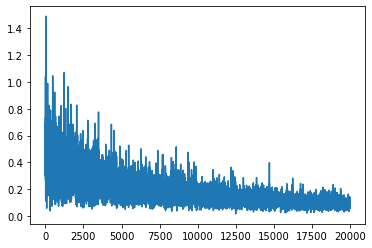

Values: 
--------------------
  0.05  0.2  0.5  0
--------------------
 -0.12  0 -0.05  0
--------------------
 -0.46 -0.53 -0.67 -0.61
Policy: 
--------------------
 R | R | R |   |
--------------------
 U |   | U |   |
--------------------
 U | U | L | L |


In [20]:
if __name__ == "__main__":
    main()